Read the train data into a [`DataFrame`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html).

In [1]:
import pandas


table = pandas.read_csv("../data/tesla/train.csv")
table["Date"] = pandas.to_datetime(table["Date"])
table

,Date,Open,High,Low,Close,Volume,Adj Close
0,2010-06-29,19.000000,25.000000,17.540001,23.889999,18766300,23.889999
1,2010-06-30,25.790001,30.420000,23.299999,23.830000,17187100,23.830000
2,2010-07-01,25.000000,25.920000,20.270000,21.959999,8218800,21.959999
3,2010-07-02,23.000000,23.100000,18.709999,19.200001,5139800,19.200001
4,2010-07-06,20.000000,20.000000,15.830000,16.110001,6866900,16.110001
...,...,...,...,...,...,...,...
1348,2015-11-04,227.000000,232.740005,225.199997,231.630005,12726400,231.630005
1349,2015-11-05,230.580002,234.580002,229.190002,231.770004,4496800,231.770004
1350,2015-11-06,230.699997,233.360001,229.500000,232.360001,2445300,232.360001
1351,2015-11-09,232.990005,232.990005,224.309998,225.330002,3850900,225.330002


Define a helper function to extract $k$ consecutive days (excluding weekends). We're going to use the data from $k - 1$ consecutive weekdays to predict the next one.

In [2]:
from collections import deque
from datetime import timedelta
from typing import Iterable


def window(
    table: pandas.DataFrame,
    *,
    k: int,
) -> Iterable[pandas.DataFrame]:
    queue = deque(maxlen=k)
    for index, item in enumerate(table.itertuples()):
        if len(queue) == k:
            yield table[index - k:index]

        temp = item.Date - timedelta(days=1)
        while temp.weekday() in [5, 6]:
            temp -= timedelta(days=1)

        if len(queue) > 0 and temp != queue[-1].Date:
            queue.clear()

        queue.append(item)

View the first input-output batch

In [3]:
CONTEXT_SIZE = 4
next(window(table, k=CONTEXT_SIZE + 1))

,Date,Open,High,Low,Close,Volume,Adj Close
4,2010-07-06,20.000000,20.000000,15.830000,16.110001,6866900,16.110001
5,2010-07-07,16.400000,16.629999,14.980000,15.800000,6921700,15.800000
6,2010-07-08,16.139999,17.520000,15.570000,17.459999,7711400,17.459999
7,2010-07-09,17.580000,17.900000,16.549999,17.400000,4050600,17.400000
8,2010-07-12,17.950001,18.070000,17.000000,17.049999,2202500,17.049999


In [4]:
import numpy


train = numpy.array([d.values for d in window(table, k=CONTEXT_SIZE + 1)])
train = train[:, :, 1:]  # Remove Date column
train.shape  # (N, CONTEXT_SIZE + 1, FEATURES)

(1160, 5, 6)

In [5]:
input = train[:, :-1, :]
input = input.reshape((input.shape[0], input.shape[1] * input.shape[2]))
output = train[:, -1, :]
input.shape, output.shape

((1160, 24), (1160, 6))

In [6]:
numpy.set_printoptions(suppress=True)
input[0]

array([20.0, 20.0, 15.83, 16.110001, 6866900, 16.110001, 16.4, 16.629999,
       14.98, 15.8, 6921700, 15.8, 16.139999, 17.52, 15.57, 17.459999,
       7711400, 17.459999, 17.58, 17.9, 16.549999, 17.4, 4050600, 17.4],
      dtype=object)

In [7]:
output[0]

array([17.950001, 18.07, 17.0, 17.049999, 2202500, 17.049999],
      dtype=object)

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error


model = LinearRegression()
model.fit(input, output)
mean_absolute_percentage_error(output, model.predict(input))

0.09037257653646062

In [9]:
table = pandas.read_csv("../data/tesla/test.csv")
table["Date"] = pandas.to_datetime(table["Date"])

train = numpy.array([d.values for d in window(table, k=CONTEXT_SIZE + 1)])
train = train[:, :, 1:]  # Remove Date column

input = train[:, :-1, :]
input = input.reshape((input.shape[0], input.shape[1] * input.shape[2]))
output = train[:, -1, :]

mean_absolute_percentage_error(output, model.predict(input))

0.07582831619347462

In [10]:
def evaluate(*, context_size: int) -> float:
    table = pandas.read_csv("../data/tesla/train.csv")
    table["Date"] = pandas.to_datetime(table["Date"])

    train = numpy.array([d.values for d in window(table, k=context_size + 1)])
    train = train[:, :, 1:]  # Remove Date column

    input = train[:, :-1, :]
    input = input.reshape((input.shape[0], input.shape[1] * input.shape[2]))
    output = train[:, -1, :]

    model = LinearRegression()
    model.fit(input, output)

    table = pandas.read_csv("../data/tesla/test.csv")
    table["Date"] = pandas.to_datetime(table["Date"])

    train = numpy.array([d.values for d in window(table, k=context_size + 1)])
    train = train[:, :, 1:]  # Remove Date column

    input = train[:, :-1, :]
    input = input.reshape((input.shape[0], input.shape[1] * input.shape[2]))
    output = train[:, -1, :]

    return mean_absolute_percentage_error(output, model.predict(input))

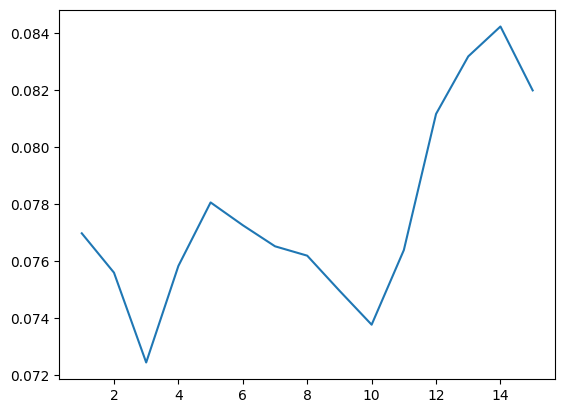

In [11]:
from matplotlib import pyplot


history = [None] + [evaluate(context_size=i) for i in range(1, 16)]
pyplot.plot(history)
pyplot.show()